In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import date, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

# Add a regression model
# Add option to aggregate at weekly level, cuz stock prices are missing for weekends
# Look at other FE based on literature
# Edit the lag function

C:\Users\Nylle\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Nylle\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\Nylle\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
stocks = ['amc', 'bb', 'clov', 'wish', 'pltr', 'tsla', 'amzn', 'nok', 'meta', 'fb']

def get_regression_df(ticker_name, comments, fin_data):
    
    ##### GET COMMENT VOLUME ######
    # Drop NA from comments
    comments = comments[~comments['created_utc'].isna()]
    
    # Grab only the ticker assignment and the date
    comment_vol_df = comments[['created_utc', 'ticker']]
    comment_vol_df['created_utc'] = pd.to_numeric(comment_vol_df['created_utc'], errors = 'coerce')

    # Remove NAs created by the coerce
    comment_vol_df = comment_vol_df[~comment_vol_df['created_utc'].isna()]
    comment_vol_df['created_utc'] = comment_vol_df['created_utc'].astype(int)
    comment_vol_df['created_utc'] = pd.to_datetime(comment_vol_df['created_utc'],unit= 's')
    comment_vol_df['date'] = comment_vol_df['created_utc'].dt.date
    comment_vol_df['date'] = pd.DatetimeIndex(comment_vol_df['date'])
    
    # Create a binary column for stock
    for stock in stocks:
        comment_vol_df[stock] = np.where(comment_vol_df['ticker'] == stock, 1, 0)
    
    aggregations = {}
    for stock in stocks:
        aggregations[stock] = np.sum
    
    comment_vol_grouped = comment_vol_df.groupby(['date']).agg(aggregations).reset_index().sort_values(['date'])
    # Only one line of weird values, drop
    comment_vol_grouped[comment_vol_grouped['date'] < pd.Timestamp('2021-01-01')]
    comment_vol_grouped=comment_vol_grouped[~(comment_vol_grouped['date'] < pd.Timestamp('2021-01-01'))]
    
    # Filter down to only the stock's data
    comment_vol_grouped = comment_vol_grouped[['date', ticker_name]]
    
    ##### BUILD EMPTY DATE DF ######
    # Build an empty df with date only
    start_date = '2021-01-01'
    end_date = '2022-01-01'

    # Generate a list of month-end closes
    start = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.datetime.strptime(end_date, "%Y-%m-%d")
    date_generated = pd.date_range(start, end, freq='D')

    # Format date columns 
    df = pd.DataFrame(date_generated)
    df.columns = ['date'] # rename column
    df = df.merge(comment_vol_grouped, how = 'left', on = 'date')
    df = df.fillna(0)
    
    ##### GET MEME PERIOD ######
    df['7_day_avg'] = df[ticker_name].rolling(7).mean() 
    df['30_day_avg'] = df[ticker_name].rolling(30).mean() 
    df['is_meme'] = np.where((df[ticker_name] > df['30_day_avg']*2)
                                 & (df[ticker_name]>df[ticker_name].quantile(0.90))
                                 , 1 ,0 )
    
    # Formatting
    df = df.drop(['7_day_avg', '30_day_avg'], axis = 1)
    df.rename(columns={ticker_name: 'comment_count'}, inplace = True)
    
    ##### JOIN POST DATA ######
    for i in range(1,8):
        if i > 1:
            roll = df['comment_count'].rolling(i).sum()
            df= df.join(roll, rsuffix = '_rolling_'+str(i)+'D')
            mean = df['comment_count'].rolling(i).mean()
            df = df.join(mean, rsuffix = '_mean_rolling_'+str(i)+'D')
        pct_change = df['comment_count'].pct_change(periods=i)*100
        df = df.join(pct_change, rsuffix= '_'+str(i)+'days_pct_change')
    df.replace([np.inf, -np.inf],100, inplace=True)
    
    ##### JOIN FINANCIAL DATA ######
    fin_data['date'] = pd.DatetimeIndex(fin_data['date'])
    fin_data = fin_data.drop(['Unnamed: 0', 'TICKER'], axis = 1)
    df = df.merge(fin_data, how = 'left', on = 'date')
    
    return df

In [3]:
#DV: DIR (classf), SD (reg), Close (reg) 
# Set all parameters here
comments = pd.read_csv('comments_preprocessed_assigned.csv')
fin_data = pd.read_csv(r'C:\Users\Nylle\`Assignments\LSTM\Stock\AMC_2021.csv')

# Call function to get regression df
df = get_regression_df(ticker_name = 'amc', 
                       comments = comments, 
                       fin_data = fin_data)
df.date = df.date.shift(1)
df.head()

,date,comment_count,is_meme,comment_count_1days_pct_change,comment_count_rolling_2D,comment_count_mean_rolling_2D,comment_count_2days_pct_change,comment_count_rolling_3D,comment_count_mean_rolling_3D,comment_count_3days_pct_change,...,6D%Change,7D%Change,Dir,2Dir,3Dir,4Dir,5Dir,6Dir,7Dir,SD
0,NaT,42.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-01,8.0,0,-80.952381,50.0,25.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-02,4.0,0,-50.000000,12.0,6.0,-90.47619,54.0,18.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-03,0.0,0,-100.000000,4.0,2.0,-100.00000,12.0,4.000000,-100.0,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.788105
4,2021-01-04,0.0,0,NaN,0.0,0.0,-100.00000,4.0,1.333333,-100.0,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.815720


In [4]:
df.columns

Index(['date', 'comment_count', 'is_meme', 'comment_count_1days_pct_change',
       'comment_count_rolling_2D', 'comment_count_mean_rolling_2D',
       'comment_count_2days_pct_change', 'comment_count_rolling_3D',
       'comment_count_mean_rolling_3D', 'comment_count_3days_pct_change',
       'comment_count_rolling_4D', 'comment_count_mean_rolling_4D',
       'comment_count_4days_pct_change', 'comment_count_rolling_5D',
       'comment_count_mean_rolling_5D', 'comment_count_5days_pct_change',
       'comment_count_rolling_6D', 'comment_count_mean_rolling_6D',
       'comment_count_6days_pct_change', 'comment_count_rolling_7D',
       'comment_count_mean_rolling_7D', 'comment_count_7days_pct_change',
       'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x', 'Daily%Change',
       '2D%Change', '3D%Change', '4D%Change', '5D%Change', '6D%Change',
       '7D%Change', 'Dir', '2Dir', '3Dir', '4Dir', '5Dir', '6Dir', '7Dir',
       'SD'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 0 to 365
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   date                            365 non-null    datetime64[ns]
 1   comment_count                   366 non-null    float64       
 2   is_meme                         366 non-null    int32         
 3   comment_count_1days_pct_change  332 non-null    float64       
 4   comment_count_rolling_2D        365 non-null    float64       
 5   comment_count_mean_rolling_2D   365 non-null    float64       
 6   comment_count_2days_pct_change  341 non-null    float64       
 7   comment_count_rolling_3D        364 non-null    float64       
 8   comment_count_mean_rolling_3D   364 non-null    float64       
 9   comment_count_3days_pct_change  344 non-null    float64       
 10  comment_count_rolling_4D        363 non-null    float64       
 11  commen

In [6]:
df = df.dropna()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 223 entries, 13 to 356
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   date                            223 non-null    datetime64[ns]
 1   comment_count                   223 non-null    float64       
 2   is_meme                         223 non-null    int32         
 3   comment_count_1days_pct_change  223 non-null    float64       
 4   comment_count_rolling_2D        223 non-null    float64       
 5   comment_count_mean_rolling_2D   223 non-null    float64       
 6   comment_count_2days_pct_change  223 non-null    float64       
 7   comment_count_rolling_3D        223 non-null    float64       
 8   comment_count_mean_rolling_3D   223 non-null    float64       
 9   comment_count_3days_pct_change  223 non-null    float64       
 10  comment_count_rolling_4D        223 non-null    float64       
 11  comme

## LSTM: AMC Close Price

In [8]:
#https://www.relataly.com/stock-market-prediction-using-multivariate-time-series-in-python/1815/#h-multivariate-prediction-models

In [9]:
# List of considered Features
FEATURES = ['comment_count', 'is_meme', 'comment_count_1days_pct_change',
       'comment_count_rolling_2D', 'comment_count_mean_rolling_2D',
       'comment_count_2days_pct_change', 'comment_count_rolling_3D',
       'comment_count_mean_rolling_3D', 'comment_count_3days_pct_change',
       'comment_count_rolling_4D', 'comment_count_mean_rolling_4D',
       'comment_count_4days_pct_change', 'comment_count_rolling_5D',
       'comment_count_mean_rolling_5D', 'comment_count_5days_pct_change',
       'comment_count_rolling_6D', 'comment_count_mean_rolling_6D',
       'comment_count_6days_pct_change', 'comment_count_rolling_7D',
       'comment_count_mean_rolling_7D', 'comment_count_7days_pct_change',
       'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x', 'Daily%Change',
       '2D%Change', '3D%Change', '4D%Change', '5D%Change', '6D%Change',
       '7D%Change', 'Dir', '2Dir', '3Dir', '4Dir', '5Dir', '6Dir', '7Dir',
       'SD']

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = df
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close_x']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['comment_count', 'is_meme', 'comment_count_1days_pct_change', 'comment_count_rolling_2D', 'comment_count_mean_rolling_2D', 'comment_count_2days_pct_change', 'comment_count_rolling_3D', 'comment_count_mean_rolling_3D', 'comment_count_3days_pct_change', 'comment_count_rolling_4D', 'comment_count_mean_rolling_4D', 'comment_count_4days_pct_change', 'comment_count_rolling_5D', 'comment_count_mean_rolling_5D', 'comment_count_5days_pct_change', 'comment_count_rolling_6D', 'comment_count_mean_rolling_6D', 'comment_count_6days_pct_change', 'comment_count_rolling_7D', 'comment_count_mean_rolling_7D', 'comment_count_7days_pct_change', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x', 'Daily%Change', '2D%Change', '3D%Change', '4D%Change', '5D%Change', '6D%Change', '7D%Change', 'Dir', '2Dir', '3Dir', '4Dir', '5Dir', '6Dir', '7Dir', 'SD']


,comment_count,is_meme,comment_count_1days_pct_change,comment_count_rolling_2D,comment_count_mean_rolling_2D,comment_count_2days_pct_change,comment_count_rolling_3D,comment_count_mean_rolling_3D,comment_count_3days_pct_change,comment_count_rolling_4D,...,7D%Change,Dir,2Dir,3Dir,4Dir,5Dir,6Dir,7Dir,SD,Prediction
348,1.0,0,-66.666667,4.0,2.0,-91.666667,16.0,5.333333,100.000000,16.0,...,-14.345262,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.770287,24.660000
350,2.0,0,100.000000,2.0,1.0,100.000000,3.0,1.000000,-33.333333,6.0,...,-9.984537,1.0,1.0,1.0,1.0,1.0,0.0,0.0,4.784107,29.120001
354,5.0,0,100.000000,5.0,2.5,100.000000,5.0,1.666667,400.000000,6.0,...,10.422736,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.143640,30.299999
355,3.0,0,-40.000000,8.0,4.0,100.000000,8.0,2.666667,100.000000,8.0,...,23.407920,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.787750,28.680000
356,2.0,0,-33.333333,5.0,2.5,-60.000000,10.0,3.333333,100.000000,10.0,...,16.408165,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.084575,28.520000


In [10]:
# Get the number of rows in the data
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close_x'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(223, 41)


In [11]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 30

# Prediction Index
index_Close = data.columns.get_loc("Close_x")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(149, 30, 41) (149,)
(44, 30, 41) (44,)
0.04945868256848823
0.04945868256848823


In [12]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

1230 30 41


In [13]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Training the model
epochs = 3 
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )

Epoch 1/3
10/10 [==============================] - 11s 967ms/step - loss: 0.7551 - val_loss: 0.0659
Epoch 2/3
10/10 [==============================] - 5s 517ms/step - loss: 0.0263 - val_loss: 0.0041
Epoch 3/3
10/10 [==============================] - 5s 543ms/step - loss: 0.0166 - val_loss: 0.0095


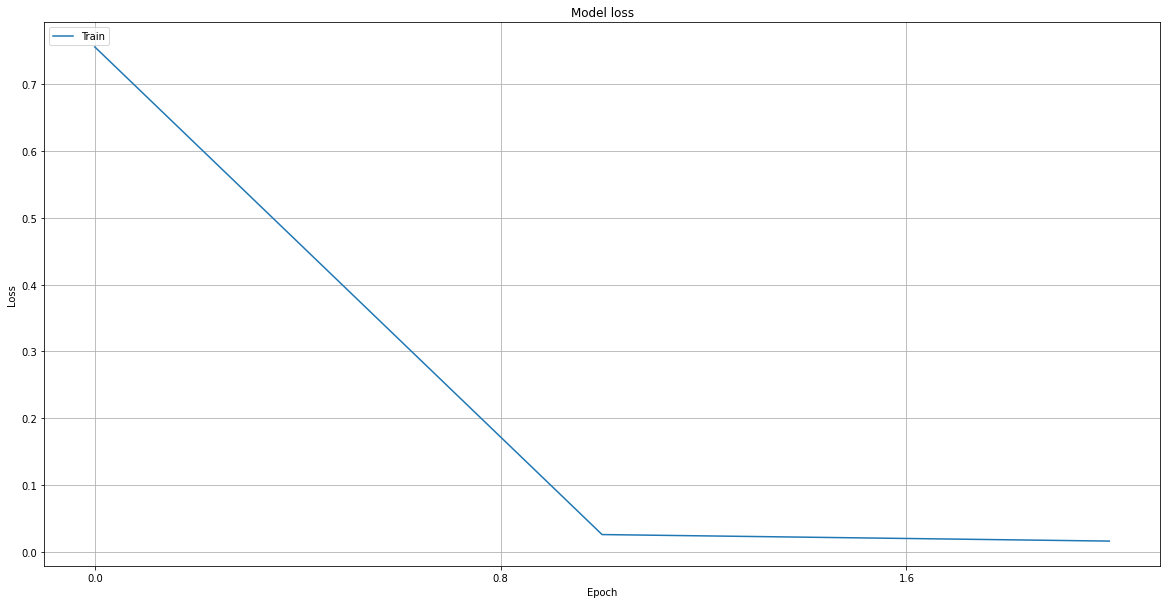

In [14]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [15]:
#recompile with epochs 3

In [16]:
from sklearn.metrics import mean_absolute_error

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
y_pred_scaled = model.predict(x_test)

for i in range(30):
    # Unscale the predicted values
    y_pred = scaler_pred.inverse_transform(y_pred_scaled[:,i,:])
    y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

    # Mean Absolute Error (MAE)
    MAE = mean_absolute_error(y_test_unscaled, y_pred)
    print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
    MAE_list.append(MAE)

    # Mean Absolute Percentage Error (MAPE)
    MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
    print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
    MAPE_list.append(MAPE)

    # Median Absolute Percentage Error (MDAPE)
    MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
    print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
    MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 4.99
Mean Absolute Percentage Error (MAPE): 148.04 %
Median Absolute Percentage Error (MDAPE): 139.75 %
Median Absolute Error (MAE): 3.2
Mean Absolute Percentage Error (MAPE): 91.01 %
Median Absolute Percentage Error (MDAPE): 88.84 %
Median Absolute Error (MAE): 1.25
Mean Absolute Percentage Error (MAPE): 38.59 %
Median Absolute Percentage Error (MDAPE): 29.26 %
Median Absolute Error (MAE): 3.71
Mean Absolute Percentage Error (MAPE): 122.37 %
Median Absolute Percentage Error (MDAPE): 113.43 %
Median Absolute Error (MAE): 4.99
Mean Absolute Percentage Error (MAPE): 163.06 %
Median Absolute Percentage Error (MDAPE): 161.14 %
Median Absolute Error (MAE): 5.31
Mean Absolute Percentage Error (MAPE): 172.32 %
Median Absolute Percentage Error (MDAPE): 151.79 %
Median Absolute Error (MAE): 5.32
Mean Absolute Percentage Error (MAPE): 173.96 %
Median Absolute Percentage Error (MDAPE): 169.15 %
Median Absolute Error (MAE): 5.38
Mean Absolute Percentage Error (MAPE): 1

,MAE,MAPE,MDAPE
0,4.991164,148.040835,139.748651
1,3.197150,91.006025,88.843320
2,1.251985,38.587630,29.261085
3,3.713674,122.365444,113.432769
4,4.987230,163.056656,161.135485
5,5.309171,172.323981,151.791002
6,5.315491,173.961301,169.149771
7,5.380805,176.319826,161.338258
8,5.414899,176.482172,161.424949
9,5.394885,175.464258,169.306810


In [17]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close_x"], True)

In [18]:
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

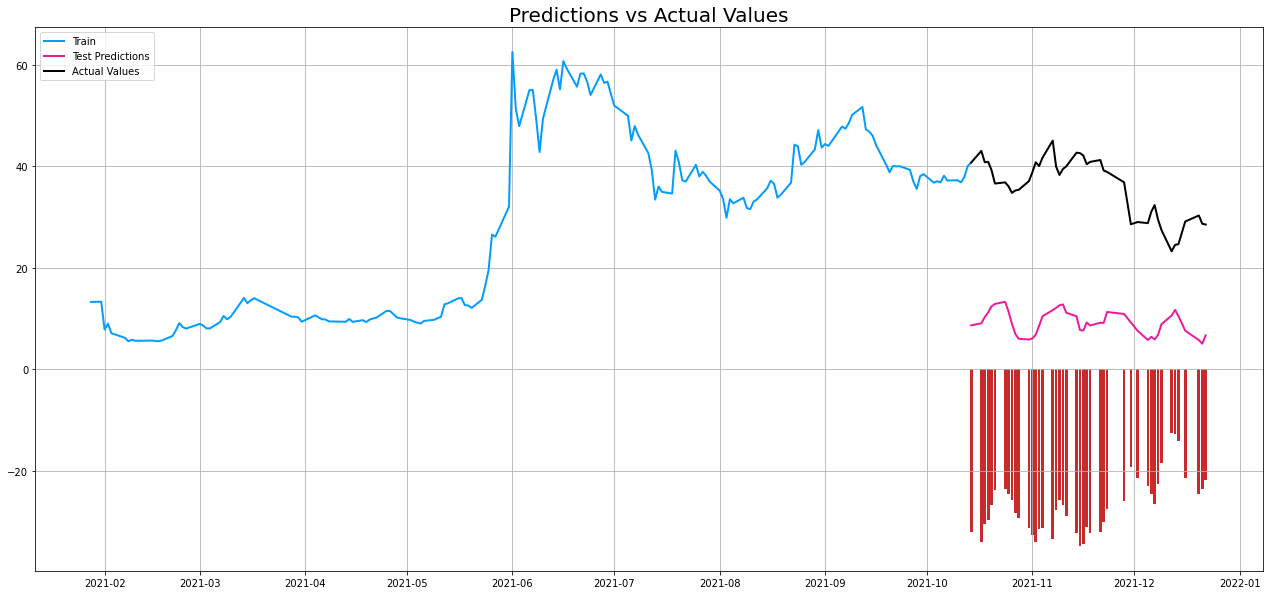

In [19]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close_x"]]
xv = valid['Date']; yv = valid[["Close_x", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close_x"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

In [20]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(last_N_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Print last price and predicted price for the next day
price_today = np.round(new_df['Close_x'], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price was {price_today}')

The close price was 307    40.05
308    41.70
311    45.06
312    39.93
313    38.29
314    39.46
315    40.00
318    42.68
319    42.60
320    42.13
321    40.41
322    40.87
325    41.24
326    39.16
327    38.89
332    36.84
334    28.57
336    29.01
339    28.79
340    31.04
341    32.35
342    29.46
343    27.44
346    23.24
347    24.50
348    24.66
350    29.12
354    30.30
355    28.68
356    28.52
Name: Close_x, dtype: float64


## LSTM: AMC Daily%Change

In [21]:
#https://www.relataly.com/stock-market-prediction-using-multivariate-time-series-in-python/1815/#h-multivariate-prediction-models

In [22]:
# List of considered Features
FEATURES = ['comment_count', 'is_meme', 'comment_count_1days_pct_change',
       'comment_count_rolling_2D', 'comment_count_mean_rolling_2D',
       'comment_count_2days_pct_change', 'comment_count_rolling_3D',
       'comment_count_mean_rolling_3D', 'comment_count_3days_pct_change',
       'comment_count_rolling_4D', 'comment_count_mean_rolling_4D',
       'comment_count_4days_pct_change', 'comment_count_rolling_5D',
       'comment_count_mean_rolling_5D', 'comment_count_5days_pct_change',
       'comment_count_rolling_6D', 'comment_count_mean_rolling_6D',
       'comment_count_6days_pct_change', 'comment_count_rolling_7D',
       'comment_count_mean_rolling_7D', 'comment_count_7days_pct_change',
       'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x', 'Daily%Change',
       '2D%Change', '3D%Change', '4D%Change', '5D%Change', '6D%Change',
       '7D%Change', 'Dir', '2Dir', '3Dir', '4Dir', '5Dir', '6Dir', '7Dir',
       'SD']

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = df
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Daily%Change']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['comment_count', 'is_meme', 'comment_count_1days_pct_change', 'comment_count_rolling_2D', 'comment_count_mean_rolling_2D', 'comment_count_2days_pct_change', 'comment_count_rolling_3D', 'comment_count_mean_rolling_3D', 'comment_count_3days_pct_change', 'comment_count_rolling_4D', 'comment_count_mean_rolling_4D', 'comment_count_4days_pct_change', 'comment_count_rolling_5D', 'comment_count_mean_rolling_5D', 'comment_count_5days_pct_change', 'comment_count_rolling_6D', 'comment_count_mean_rolling_6D', 'comment_count_6days_pct_change', 'comment_count_rolling_7D', 'comment_count_mean_rolling_7D', 'comment_count_7days_pct_change', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x', 'Daily%Change', '2D%Change', '3D%Change', '4D%Change', '5D%Change', '6D%Change', '7D%Change', 'Dir', '2Dir', '3Dir', '4Dir', '5Dir', '6Dir', '7Dir', 'SD']


,comment_count,is_meme,comment_count_1days_pct_change,comment_count_rolling_2D,comment_count_mean_rolling_2D,comment_count_2days_pct_change,comment_count_rolling_3D,comment_count_mean_rolling_3D,comment_count_3days_pct_change,comment_count_rolling_4D,...,7D%Change,Dir,2Dir,3Dir,4Dir,5Dir,6Dir,7Dir,SD,Prediction
348,1.0,0,-66.666667,4.0,2.0,-91.666667,16.0,5.333333,100.000000,16.0,...,-14.345262,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.770287,0.653061
350,2.0,0,100.000000,2.0,1.0,100.000000,3.0,1.000000,-33.333333,6.0,...,-9.984537,1.0,1.0,1.0,1.0,1.0,0.0,0.0,4.784107,19.100204
354,5.0,0,100.000000,5.0,2.5,100.000000,5.0,1.666667,400.000000,6.0,...,10.422736,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.143640,2.020197
355,3.0,0,-40.000000,8.0,4.0,100.000000,8.0,2.666667,100.000000,8.0,...,23.407920,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.787750,-5.346531
356,2.0,0,-33.333333,5.0,2.5,-60.000000,10.0,3.333333,100.000000,10.0,...,16.408165,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.084575,-0.557880


In [23]:
# Get the number of rows in the data
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Daily%Change'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(223, 41)


In [24]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 30

# Prediction Index
index_Close = data.columns.get_loc("Daily%Change")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(149, 30, 41) (149,)
(44, 30, 41) (44,)
0.07909801768183211
0.07909801768183211


In [25]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

1230 30 41


In [26]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Training the model
epochs = 2
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )

Epoch 1/2
10/10 [==============================] - 7s 596ms/step - loss: 0.2752 - val_loss: 0.0194
Epoch 2/2
10/10 [==============================] - 5s 541ms/step - loss: 0.0103 - val_loss: 0.0023


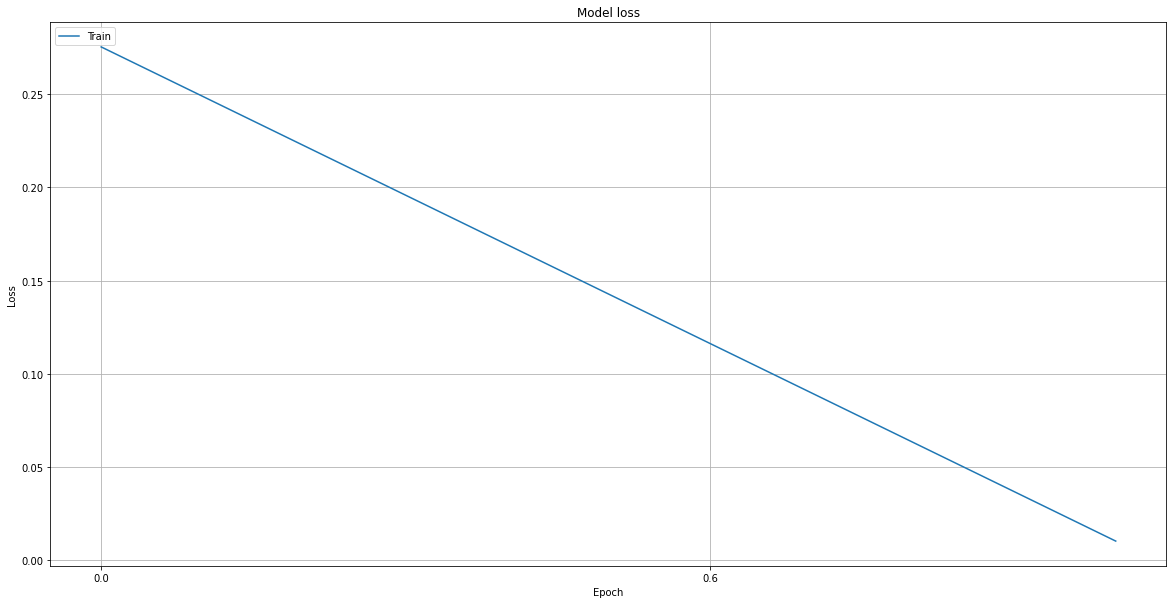

In [27]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [28]:
#recompile with 2 epochs

In [29]:
from sklearn.metrics import mean_absolute_error

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
y_pred_scaled = model.predict(x_test)

for i in range(30):
    # Unscale the predicted values
    y_pred = scaler_pred.inverse_transform(y_pred_scaled[:,i,:])
    y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

    # Mean Absolute Error (MAE)
    MAE = mean_absolute_error(y_test_unscaled, y_pred)
    print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
    MAE_list.append(MAE)

    # Mean Absolute Percentage Error (MAPE)
    MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
    print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
    MAPE_list.append(MAPE)

    # Median Absolute Percentage Error (MDAPE)
    MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
    print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
    MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 44.48
Mean Absolute Percentage Error (MAPE): 308.83 %
Median Absolute Percentage Error (MDAPE): 204.85 %
Median Absolute Error (MAE): 34.2
Mean Absolute Percentage Error (MAPE): 246.36 %
Median Absolute Percentage Error (MDAPE): 174.98 %
Median Absolute Error (MAE): 19.2
Mean Absolute Percentage Error (MAPE): 152.16 %
Median Absolute Percentage Error (MDAPE): 94.35 %
Median Absolute Error (MAE): 11.86
Mean Absolute Percentage Error (MAPE): 90.74 %
Median Absolute Percentage Error (MDAPE): 50.34 %
Median Absolute Error (MAE): 11.44
Mean Absolute Percentage Error (MAPE): 74.26 %
Median Absolute Percentage Error (MDAPE): 62.26 %
Median Absolute Error (MAE): 11.98
Mean Absolute Percentage Error (MAPE): 72.96 %
Median Absolute Percentage Error (MDAPE): 62.6 %
Median Absolute Error (MAE): 11.9
Mean Absolute Percentage Error (MAPE): 72.14 %
Median Absolute Percentage Error (MDAPE): 61.36 %
Median Absolute Error (MAE): 11.84
Mean Absolute Percentage Error (MAPE): 7

,MAE,MAPE,MDAPE
0,44.478471,308.832755,204.851901
1,34.200600,246.363909,174.978560
2,19.200244,152.156092,94.347123
3,11.861300,90.735829,50.340502
4,11.443839,74.263846,62.261623
5,11.978277,72.959769,62.599359
6,11.895350,72.144864,61.355363
7,11.843977,70.281084,56.042261
8,10.982178,65.055504,46.752898
9,10.604804,64.719378,50.986401


In [30]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Daily%Change"], True)

In [31]:
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

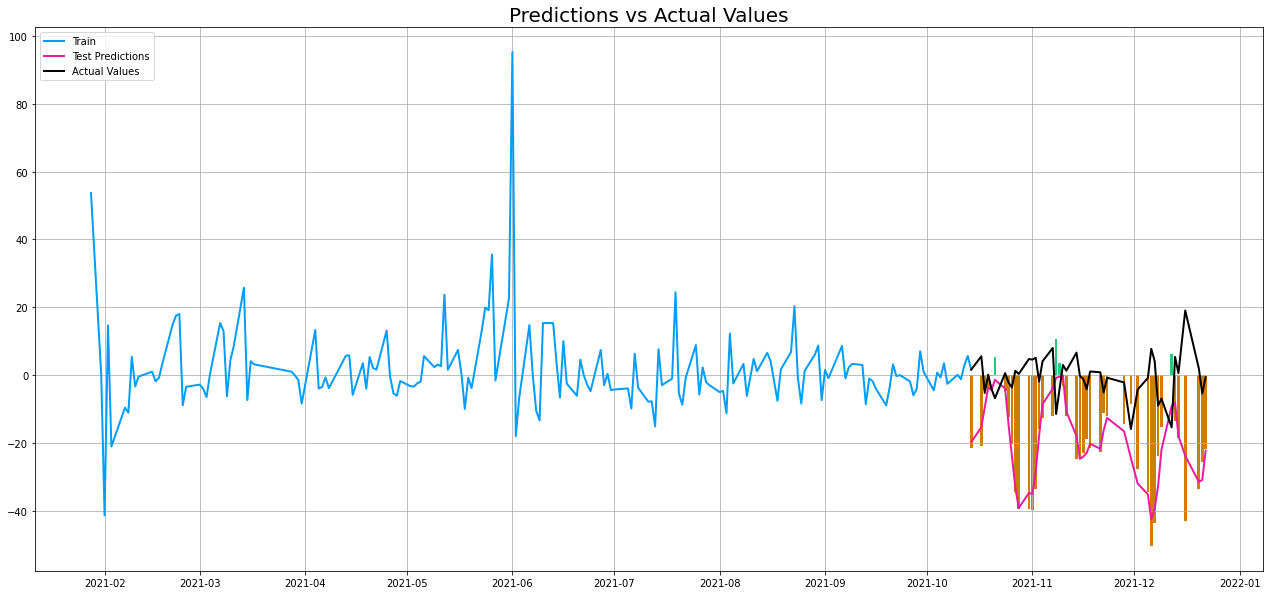

In [32]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Daily%Change"]]
xv = valid['Date']; yv = valid[["Daily%Change", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Daily%Change"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A" #green gain
valid.loc[y < 0, 'diff_color'] = "#ce7e00" #brown loss

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

In [33]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(last_N_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Print last price and predicted price for the next day
price_today = np.round(new_df['Daily%Change'], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The Daily%Change was {price_today}')

The Daily%Change was 307    -1.81
308     4.12
311     8.06
312   -11.38
313    -4.11
314     3.06
315     1.37
318     6.70
319    -0.19
320    -1.10
321    -4.08
322     1.14
325     0.91
326    -5.04
327    -0.69
332    -2.10
334   -15.82
336    -4.19
339    -0.76
340     7.82
341     4.22
342    -8.93
343    -6.86
346   -15.31
347     5.42
348     0.65
350    19.10
354     2.02
355    -5.35
356    -0.56
Name: Daily%Change, dtype: float64
